In [1]:
import numpy as np
import torch
import os
import net_low as net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 64
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 1
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = True
RUN_NAME = '8x2x2'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:1


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|█████████████████████████████████████████| 610/610 [02:07<00:00,  4.80it/s]


Epoch: 1 	Training Loss: 0.051698 	Val Loss: 0.044661	     in time 2.194250m


100%|█████████████████████████████████████████| 610/610 [02:05<00:00,  4.87it/s]


Epoch: 2 	Training Loss: 0.041166 	Val Loss: 0.036077	     in time 2.154516m


100%|█████████████████████████████████████████| 610/610 [02:08<00:00,  4.73it/s]


Epoch: 3 	Training Loss: 0.022561 	Val Loss: 0.014062	     in time 2.211799m


100%|█████████████████████████████████████████| 610/610 [02:09<00:00,  4.70it/s]


Epoch: 4 	Training Loss: 0.010433 	Val Loss: 0.007531	     in time 2.235987m


100%|█████████████████████████████████████████| 610/610 [02:10<00:00,  4.68it/s]


Epoch: 5 	Training Loss: 0.006572 	Val Loss: 0.005846	     in time 2.244539m


100%|█████████████████████████████████████████| 610/610 [02:10<00:00,  4.67it/s]


Epoch: 6 	Training Loss: 0.005474 	Val Loss: 0.005184	     in time 2.254652m


100%|█████████████████████████████████████████| 610/610 [02:11<00:00,  4.65it/s]


Epoch: 7 	Training Loss: 0.005062 	Val Loss: 0.004855	     in time 2.259264m


100%|█████████████████████████████████████████| 610/610 [02:12<00:00,  4.62it/s]


Epoch: 8 	Training Loss: 0.004802 	Val Loss: 0.004682	     in time 2.271079m


100%|█████████████████████████████████████████| 610/610 [02:12<00:00,  4.60it/s]


Epoch: 9 	Training Loss: 0.004620 	Val Loss: 0.004440	     in time 2.281517m


100%|█████████████████████████████████████████| 610/610 [02:13<00:00,  4.59it/s]


Epoch: 10 	Training Loss: 0.004369 	Val Loss: 0.004238	     in time 2.287908m


100%|█████████████████████████████████████████| 610/610 [02:14<00:00,  4.54it/s]


Epoch: 11 	Training Loss: 0.004199 	Val Loss: 0.004078	     in time 2.307126m


100%|█████████████████████████████████████████| 610/610 [02:14<00:00,  4.54it/s]


Epoch: 12 	Training Loss: 0.004093 	Val Loss: 0.003999	     in time 2.317019m


100%|█████████████████████████████████████████| 610/610 [02:13<00:00,  4.57it/s]


Epoch: 13 	Training Loss: 0.004028 	Val Loss: 0.003972	     in time 2.296389m


100%|█████████████████████████████████████████| 610/610 [02:13<00:00,  4.55it/s]


Epoch: 14 	Training Loss: 0.003964 	Val Loss: 0.003873	     in time 2.305187m


100%|█████████████████████████████████████████| 610/610 [02:15<00:00,  4.51it/s]


Epoch: 15 	Training Loss: 0.003914 	Val Loss: 0.003873	     in time 2.324738m


100%|█████████████████████████████████████████| 610/610 [02:16<00:00,  4.48it/s]


Epoch: 16 	Training Loss: 0.003865 	Val Loss: 0.003797	     in time 2.341453m


100%|█████████████████████████████████████████| 610/610 [02:14<00:00,  4.54it/s]


Epoch: 17 	Training Loss: 0.003801 	Val Loss: 0.003755	     in time 2.310556m


100%|█████████████████████████████████████████| 610/610 [02:16<00:00,  4.48it/s]


Epoch: 18 	Training Loss: 0.003807 	Val Loss: 0.003758	     in time 2.340682m


100%|█████████████████████████████████████████| 610/610 [02:16<00:00,  4.48it/s]


Epoch: 19 	Training Loss: 0.003768 	Val Loss: 0.003668	     in time 2.344689m


100%|█████████████████████████████████████████| 610/610 [02:11<00:00,  4.64it/s]


Epoch: 20 	Training Loss: 0.003722 	Val Loss: 0.003732	     in time 2.258491m
CPU times: user 36min 39s, sys: 11min 31s, total: 48min 10s
Wall time: 45min 32s


# Results

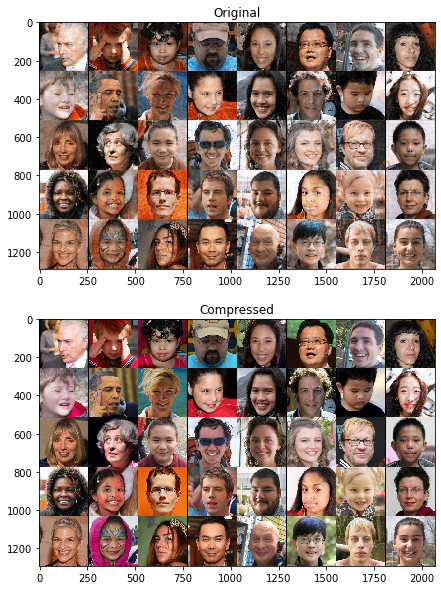

In [12]:
utils.show(val_true_grid,val_pred_grid)

In [13]:
path = Path("results") / RUN_NAME

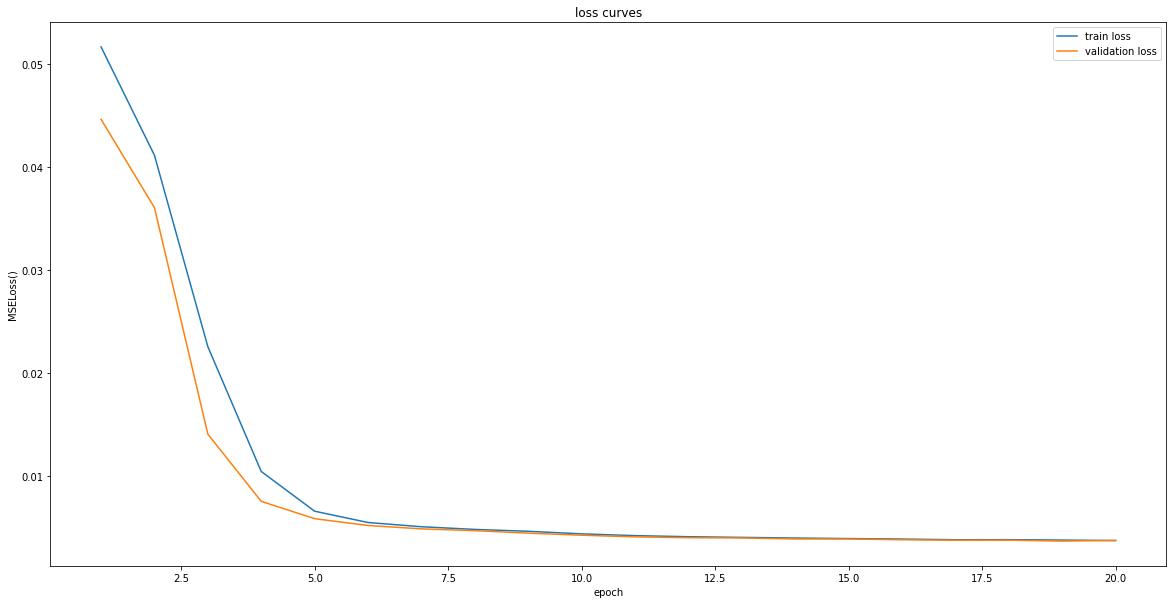

In [14]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [15]:
utils.write_losses(path, train_losses, val_losses)

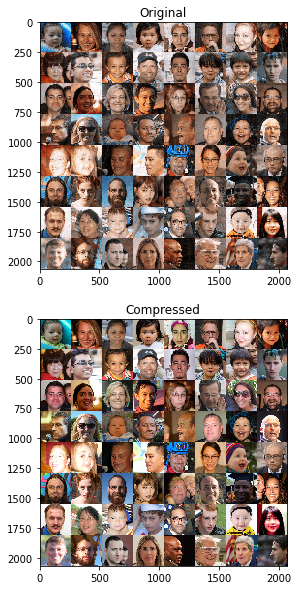

In [16]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)